In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.optimize import root_scalar as root

D:\Mark\Python\lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
def Omega(n,m,eta):
    return np.abs(np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2))             #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar
    
eta = 0.1
Ncut = 1000
omegas = np.zeros(Ncut)
#probs = np.zeros(Ncut)
#nbar = 10
for n in range(Ncut):
    omegas[n] = Omega(n,0,eta)
    #probs[n] = prob(n,nbar)

D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_or

In [3]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

def expE(nbar, omega, Ncut):
    expE = 0.0
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def dopAndStark(nbar): #gives instantaneous doppler and stark shift in angular frequency units
    Ncut = 1201
    omega = 2.0*np.pi*778e3 #Lange
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -2.0*np.pi*nu0*expE(nbar, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
#from Lange eqns 2.11 and 2.12

In [4]:
def rhoee(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,1]))**2.0
    return result

def rhogg(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,0]))**2.0
    return result

def psi(g,e):
    return np.array([g, e])

def groundPsi(Ncut):
    result = np.zeros((Ncut,2),dtype="complex")
    result[:,0] = 1.
    return result

def subPulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def pulse(psi, t, Omega0, delta, phi0, phi1):
    Ncut = np.shape(psi)[0]
    result = np.zeros((Ncut,2),dtype="complex")
    if (Omega0==0):
        subpulse = subPulse(t, Omega0, delta, phi0, phi1)
        for n in range(Ncut):
            result[n,:] = subpulse@psi[n,:]
    else:
        for n in range(Ncut):
            result[n,:] = subPulse(t, Omega0*omegas[n], delta, phi0, phi1)@psi[n,:]
    return result

In [5]:
def HR(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0.
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(psiP, t2, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(psiM, t2, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

def HRJump(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(pulse(psiP, 2.0*t2/3.0, -Omega0, delp2, 0.0, 0.0), t2/3.0, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(pulse(psiM, 2.0*t2/3.0, -Omega0, delp2, 0.0, 0.0), t2/3.0, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

def HRJumpFront(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(2.0*t1/3.0, -Omega0, delp1, 0.0, 0.0)@subPulse(t1/3.0, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(psiP, t2, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(psiM, t2, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

In [6]:
def HRAp(deld, psi0, t, T, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, 0.0)@subPulse(t, Omega0, delp1, np.pi/2.0, -np.pi/2.0)@psi0
    psi = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psi[n,:] = intState
    psi = pulse(pulse(psi, 2.0*t, Omega0, delp2, np.pi, -np.pi), t, Omega0, delp2, 0.0, 0.0)
    return psi

def HRAn(deld, psi0, t, T, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, 0.0)@subPulse(t, Omega0, delp1, -np.pi/2.0, np.pi/2.0)@psi0
    psi = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psi[n,:] = intState
    psi = pulse(pulse(psi, 2.0*t, Omega0, delp2, np.pi, -np.pi), t, Omega0, delp2, 0.0, 0.0)
    return psi

def HRBp(deld, psi0, t, T, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, 0.0)@subPulse(t, Omega0, delp1, 0.0, 0.0)@psi0
    psi = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psi[n,:] = intState
    psi = pulse(pulse(psi, 2.0*t, Omega0, delp2, np.pi, -np.pi/2.0), t, Omega0, delp2, 0.0, -np.pi/2.0)
    return psi

def HRBn(deld, psi0, t, T, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, 0.0)@subPulse(t, Omega0, delp1, 0.0, 0.0)@psi0
    psi = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psi[n,:] = intState
    psi = pulse(pulse(psi, 2.0*t, Omega0, delp2, np.pi, -3.0*np.pi/2.0), t, Omega0, delp2, 0.0, np.pi/2.0)
    return psi

def MHR1(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut):
    return rhoee(HRAp(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut),nbarf) - rhoee(HRBn(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut),nbarf)


def MHR2(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut):
    return rhoee(HRBp(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut),nbarf) - rhoee(HRAn(deld, psi0, t, T, delp1, delp2, Omega0, nbarf, Ncut),nbarf)

In [9]:
def shiftCurve(func, t1, T, t2, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -0.5
    x1 = 0.5
    guessTol = 2.0
    tol = 1e-6
    pts = np.size(nbarfs)
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

def shiftCurve2(func, t, T, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -0.1
    x1 = 0.1
    guessTol = 2.0
    tol = 1e-6
    pts = np.size(nbarfs)
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t, T, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

In [43]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(0.2,0.6, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 30, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 40e-3
T = 500e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    
shifts0 = shiftCurve(HRJumpFront, t1, T, t2, 0., 0., Omega0, nbarfs, Ncut)

-0.00037087969595943744
[-2.0003708796959594, 1.9996291203040406]
-0.00016330202668974093
[-2.0001633020266896, 1.9998366979733102]
-0.0001419435981362793
[-2.0001419435981362, 1.9998580564018638]
-0.0002724448273299254
[-2.00027244482733, 1.99972755517267]
-0.0005266808701514094
[-2.0005266808701516, 1.9994733191298486]
-0.0008817154537940352
[-2.000881715453794, 1.9991182845462059]
-0.0013186377132111417
[-2.001318637713211, 1.998681362286789]
-0.0018217644662331049
[-2.001821764466233, 1.998178235533767]
-0.0023782033224178925
[-2.002378203322418, 1.9976217966775822]
-0.0029775273436972944
[-2.002977527343697, 1.9970224726563026]
-0.0005245777381640033
[-2.000524577738164, 1.999475422261836]
-0.00010138571582023899
[-2.00010138571582, 1.9998986142841797]
9.891968851741842e-05
[-1.9999010803114825, 2.0000989196885173]
0.00011743826031578016
[-1.9998825617396843, 2.000117438260316]
-1.2192290346392156e-05
[-2.000012192290346, 1.9999878077096536]
-0.00026253224708792965
[-2.00026253224

$\delta_p = $0.2, max abs val of shift = 0.4738881949407052
$\delta_p = $0.24, max abs val of shift = 0.32996246121990314
$\delta_p = $0.28, max abs val of shift = 0.19797941661158192
$\delta_p = $0.32, max abs val of shift = 0.1699510799782939
$\delta_p = $0.36, max abs val of shift = 0.23568115403994006
$\delta_p = $0.4, max abs val of shift = 0.3190341770139826
$\delta_p = $0.44, max abs val of shift = 0.4217452837742694
$\delta_p = $0.48, max abs val of shift = 0.5456018764467354
$\delta_p = $0.52, max abs val of shift = 0.6923640990276434
$\delta_p = $0.56, max abs val of shift = 0.8637398873008463
$\delta_p = $0.6, max abs val of shift = 1.0613927862873749


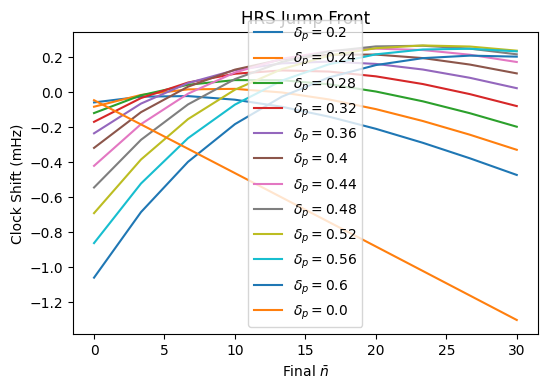

In [44]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
    maxshift = np.max(np.abs(1e3*results[ii,:]/(2.0*np.pi)))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", max abs val of shift = "+ str(maxshift))
    
plt.plot(nbarfs, 1e3*shifts0/(2.0*np.pi), label=r"$\delta_p = $" + str(0.0))
plt.legend()
plt.title("HRS Jump Front")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

In [45]:
for ii in range(delPts):
    avg = np.mean(1e3*results[ii,:]/(2.*np.pi))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", avg shift value = "+ str(avg))

$\delta_p = $0.2, avg shift value = -0.1727324404266541
$\delta_p = $0.24, avg shift value = -0.09449704096937447
$\delta_p = $0.28, avg shift value = -0.028175594252006837
$\delta_p = $0.32, avg shift value = 0.0242988910401739
$\delta_p = $0.36, avg shift value = 0.06104363814157966
$\delta_p = $0.4, avg shift value = 0.08017018487375147
$\delta_p = $0.44, avg shift value = 0.07986098391650391
$\delta_p = $0.48, avg shift value = 0.05831209825233874
$\delta_p = $0.52, avg shift value = 0.013767459144715197
$\delta_p = $0.56, avg shift value = -0.05548825674124329
$\delta_p = $0.6, avg shift value = -0.15112596216298455


$\delta_p = $0.2, avg abs value of slope = 0.05419260903086579
$\delta_p = $0.24, avg abs value of slope = 0.05009259561771207
$\delta_p = $0.28, avg abs value of slope = 0.05060754370813611
$\delta_p = $0.32, avg abs value of slope = 0.055345310493618155
$\delta_p = $0.36, avg abs value of slope = 0.062495169538874386
$\delta_p = $0.4, avg abs value of slope = 0.07127958733313716
$\delta_p = $0.44, avg abs value of slope = 0.0830050726944863
$\delta_p = $0.48, avg abs value of slope = 0.09556123143474055
$\delta_p = $0.52, avg abs value of slope = 0.10991611280883151
$\delta_p = $0.56, avg abs value of slope = 0.1251784412946711
$\delta_p = $0.6, avg abs value of slope = 0.14178581357034417


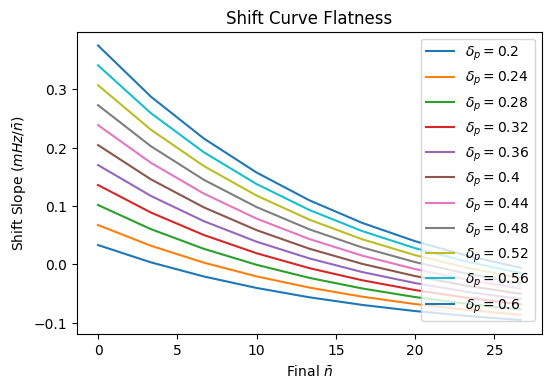

In [46]:
plt.figure(figsize=(6,4), dpi=100)
derivs = np.zeros([delPts, nbarfPts-1])
for ii in range(delPts):
    for jj in range(nbarfPts-1):
        derivs[ii,jj] = results[ii,jj+1] - results[ii,jj]
    
for ii in range(delPts):
    plt.plot(nbarfs[:9], 1e3*derivs[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
    avg = np.mean(1e3*np.abs(derivs[ii,:])/(2.0*np.pi))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", avg abs value of slope = "+ str(avg))
    
plt.legend()    
plt.title("Shift Curve Flatness")    
plt.ylabel(r"Shift Slope $(mHz/\bar{n})$")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

Now same tests again for different Pi times

In [57]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(0.2, 0.8, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 30, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t2 = 20e-3
T = 500e-3
t1 = 3.*t2
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpFront, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    
shifts0 = shiftCurve(HRJumpFront, t1, T, t2, 0., 0., Omega0, nbarfs, Ncut)

-0.00023264060542806556
[-2.0002326406054283, 1.999767359394572]
-0.000612717187976309
[-2.0006127171879764, 1.9993872828120236]
-0.0010859439964362074
[-2.0010859439964364, 1.9989140560035639]
-0.0016351232046393444
[-2.001635123204639, 1.9983648767953606]
-0.0022461868633474186
[-2.0022461868633474, 1.9977538131366526]
-0.0029076628026759605
[-2.002907662802676, 1.997092337197324]
-0.0036100925858942737
[-2.003610092585894, 1.9963899074141058]
-0.004345632347435027
[-2.004345632347435, 1.9956543676525649]
-0.005107834160740207
[-2.0051078341607402, 1.9948921658392598]
-0.005891483241031719
[-2.0058914832410317, 1.9941085167589683]
-0.0002446468091500429
[-2.00024464680915, 1.9997553531908498]
-0.0004628900032419083
[-2.000462890003242, 1.999537109996758]
-0.0008017929151407731
[-2.0008017929151407, 1.9991982070848593]
-0.0012391171760073726
[-2.0012391171760076, 1.9987608828239927]
-0.0017566544329383133
[-2.0017566544329384, 1.9982433455670616]
-0.0023395507297879147
[-2.00233955072

$\delta_p = $0.2, max abs val of shift = 0.9376586799532584
$\delta_p = $0.26, max abs val of shift = 0.8131820522475666
$\delta_p = $0.32, max abs val of shift = 0.6923757802225661
$\delta_p = $0.38, max abs val of shift = 0.5760785225966318
$\delta_p = $0.44, max abs val of shift = 0.46512383601637075
$\delta_p = $0.5, max abs val of shift = 0.3603392610996097
$\delta_p = $0.56, max abs val of shift = 0.2625454299900228
$\delta_p = $0.62, max abs val of shift = 0.1725551984652205
$\delta_p = $0.68, max abs val of shift = 0.200698934282775
$\delta_p = $0.74, max abs val of shift = 0.2548027607886697
$\delta_p = $0.8, max abs val of shift = 0.3190341770139826


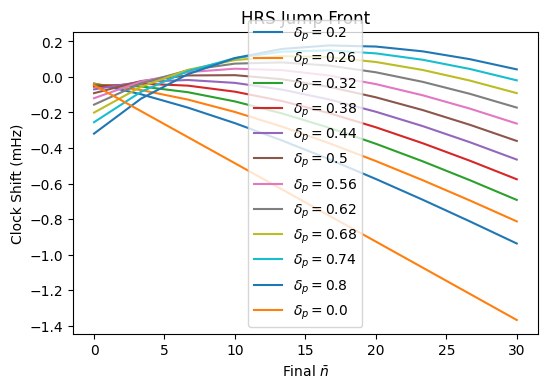

In [58]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
    maxshift = np.max(np.abs(1e3*results[ii,:]/(2.0*np.pi)))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", max abs val of shift = "+ str(maxshift))
    
plt.plot(nbarfs, 1e3*shifts0/(2.0*np.pi), label=r"$\delta_p = $" + str(0.0))
plt.legend()
plt.title("HRS Jump Front")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

In [59]:
for ii in range(delPts):
    avg = np.mean(1e3*results[ii,:]/(2.*np.pi))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", avg shift value = "+ str(avg))

$\delta_p = $0.2, avg shift value = -0.44046635014856034
$\delta_p = $0.26, avg shift value = -0.36529412998251526
$\delta_p = $0.32, avg shift value = -0.2937842771540189
$\delta_p = $0.38, avg shift value = -0.2267736298658524
$\delta_p = $0.44, avg shift value = -0.16509392504764758
$\delta_p = $0.5, avg shift value = -0.10957088452299044
$\delta_p = $0.56, avg shift value = -0.06102332267823696
$\delta_p = $0.62, avg shift value = -0.020262278682474096
$\delta_p = $0.68, avg shift value = 0.011917781581782555
$\delta_p = $0.74, avg shift value = 0.034707944643415485
$\delta_p = $0.8, avg shift value = 0.04733337325847363


$\delta_p = $0.2, avg abs value of slope = 0.10007030862616562
$\delta_p = $0.26, avg abs value of slope = 0.08602725591774198
$\delta_p = $0.32, avg abs value of slope = 0.07198655022274547
$\delta_p = $0.38, avg abs value of slope = 0.061674270244214596
$\delta_p = $0.44, avg abs value of slope = 0.05561995538955811
$\delta_p = $0.5, avg abs value of slope = 0.05240262209731392
$\delta_p = $0.56, avg abs value of slope = 0.052788769667357086
$\delta_p = $0.62, avg abs value of slope = 0.05470113350566105
$\delta_p = $0.68, avg abs value of slope = 0.058378873850903075
$\delta_p = $0.74, avg abs value of slope = 0.06365632403536998
$\delta_p = $0.8, avg abs value of slope = 0.07011030789140182


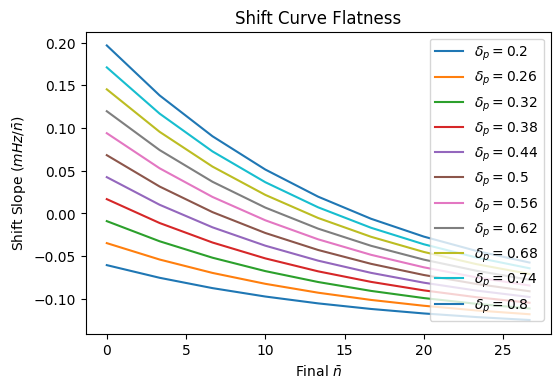

In [60]:
plt.figure(figsize=(6,4), dpi=100)
derivs = np.zeros([delPts, nbarfPts-1])
for ii in range(delPts):
    for jj in range(nbarfPts-1):
        derivs[ii,jj] = results[ii,jj+1] - results[ii,jj]
    
for ii in range(delPts):
    plt.plot(nbarfs[:9], 1e3*derivs[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
    avg = np.mean(1e3*np.abs(derivs[ii,:])/(2.0*np.pi))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", avg abs value of slope = "+ str(avg))
    
plt.legend()    
plt.title("Shift Curve Flatness")    
plt.ylabel(r"Shift Slope $(mHz/\bar{n})$")
plt.xlabel(r"Final $\bar{n}$")
plt.show()